### Installing dependencies and cloning the database

First install uv, then use it to install dependencies

``` bash
!curl -LsSf https://astral.sh/uv/install.sh | sh
```
Create a new environment and install dependencies
``` bash
!uv venv
!source .venv/bin/activate # on windows use ".venv\Scripts\activate"
!uv pip install -r requirements.txt
```

And then clone the database repo
``` bash
!git clone https://github.com/woct0rdho/pkuholebackup.git
```

In [160]:
import pandas as pd
from scipy.interpolate import make_interp_spline
import numpy as np  # You'll also need numpy for the linspace function
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

### Defining the parsing function

In [139]:

def parse_data(text):
    data = {
        'YEAR': [],
        'DATE': [],
        'TIME': [],
        'ID': [],
        'POST': [],
        'COMMENTS': [],
        'COMMENT_COUNT': []
    }
    
    current_post = None
    current_comments = []
    
    lines = text.strip().split('\n')
    
    i = 0
    while i < len(lines):
        line = lines[i]
        if line.startswith('#p'):
            # If we have a previous post, save it
            if current_post is not None:
                data['YEAR'].append(int(current_post['date'][:4]))
                data['DATE'].append(current_post['date'])
                data['TIME'].append(current_post['time'])
                data['ID'].append(int(current_post['id']))
                data['POST'].append(current_post['content'])
                data['COMMENTS'].append(current_comments)
                data['COMMENT_COUNT'].append(len(current_comments))
            
            # Parse new post
            parts = line.split()
            current_post = {
                'id': parts[1],
                'date': parts[2],
                'time': parts[3],
                'content': ''
            }
            current_comments = []
            
            # Get post content from next line if it exists
            if i + 1 < len(lines) and not lines[i + 1].startswith('#'):
                current_post['content'] = lines[i + 1].strip()
                i += 1  # Skip the content line
            
        elif line.startswith('#c'):
            # Parse comment
            if i + 1 < len(lines):  # Make sure we have a next line
                comment_text = lines[i + 1].strip()  # Get next line for comment content
                current_comments.append(comment_text)
                i += 1  # Skip the comment content line
            
        i += 1
    
    # Don't forget to add the last post
    if current_post is not None:
        data['YEAR'].append(int(current_post['date'][:4]))
        data['DATE'].append(current_post['date'])
        data['TIME'].append(current_post['time'])
        data['ID'].append(int(current_post['id']))
        data['POST'].append(current_post['content'])
        data['COMMENTS'].append(current_comments)
        data['COMMENT_COUNT'].append(len(current_comments))
    # Create DataFrame
    df = pd.DataFrame(data)
    return df

### Importing New Data (2023-2024)

In [140]:
new_df = pd.read_csv('treehole_gsm_2324.csv')

print(new_df.shape)
new_df.head()

(15606, 5)


,pid,createtime,reply,length,text
0,5239073,2023/6/30 20:58,0,382,【招聘岗位】国泰君安证券投资银行部日常实习生（股权方向，上海总部）\n\n【工作内容】\nI...
1,5239164,2023/6/30 21:22,24,159,或许会有低年级学弟学妹有改简历的需要咩\ndz不是很大佬的实习怪，但是也算有一点点经验，跨专...
2,5239245,2023/6/30 21:43,3,17,最后一句话：我恨你，gsm，真下头
3,5239298,2023/6/30 22:00,3,100,gsm19的dz感觉到大四马上毕业了还是有很多gsm19的同学互相不认识，不知道是只有不太s...
4,5239302,2023/6/30 22:01,0,11,5239298\ngsm


In [141]:
# df.head()

### Iterating through all files

In [142]:
import os
import pandas as pd
from tqdm import tqdm
def process_all_files():
    # Initialize empty list to store all dataframes
    all_dfs = []
    
    # Get the archive directory path
    archive_dir = 'pkuholebackup/archive'
    
    # Walk through all subdirectories
    for root, dirs, files in tqdm(os.walk(archive_dir), desc="Walking through directories"):
        for file in files:
            if file.endswith('.txt'):
                # Construct full file path
                file_path = os.path.join(root, file)
                try:
                    # Read the file
                    with open(file_path, 'r', encoding='utf-8') as f:
                        text = f.read()
                    
                    # Parse the data
                    df = parse_data(text)
                    
                    # Add source file information
                    df['SOURCE_FILE'] = file
                    
                    # Append to list of dataframes
                    all_dfs.append(df)
                    
                    # print(f"Processed: {file_path}")
                except Exception as e:
                    print(f"Error processing {file_path}: {str(e)}")
    
    # Combine all dataframes
    if all_dfs:
        final_df = pd.concat(all_dfs, ignore_index=True)
        return final_df
    else:
        return pd.DataFrame()

# Run the processing
combined_df = process_all_files()

Walking through directories: 73it [00:05, 13.48it/s]


In [143]:
combined_df.shape

(990962, 8)

In [144]:
# combined_df.to_csv('pkuhole_combined.csv', index=False)

In [145]:
new_df.head()

,pid,createtime,reply,length,text
0,5239073,2023/6/30 20:58,0,382,【招聘岗位】国泰君安证券投资银行部日常实习生（股权方向，上海总部）\n\n【工作内容】\nI...
1,5239164,2023/6/30 21:22,24,159,或许会有低年级学弟学妹有改简历的需要咩\ndz不是很大佬的实习怪，但是也算有一点点经验，跨专...
2,5239245,2023/6/30 21:43,3,17,最后一句话：我恨你，gsm，真下头
3,5239298,2023/6/30 22:00,3,100,gsm19的dz感觉到大四马上毕业了还是有很多gsm19的同学互相不认识，不知道是只有不太s...
4,5239302,2023/6/30 22:01,0,11,5239298\ngsm


In [146]:
def transform_new_df(df):
    # Create a copy to avoid modifying the original
    transformed = pd.DataFrame()
    
    # Convert pid to ID
    transformed['ID'] = df['pid'].astype(float)
    
    # Convert time to separate DATE and TIME columns
    transformed['DATE'] = pd.to_datetime(df['createtime']).dt.date.astype(str)
    transformed['TIME'] = pd.to_datetime(df['createtime']).dt.time.astype(str)
    transformed['YEAR'] = pd.to_datetime(df['createtime']).dt.year.astype(float)
    
    # Get the post content (last column)
    transformed['POST'] = df.iloc[:, -1]
    
    # Initialize empty comments and comment count
    transformed['COMMENTS'] = [[] for _ in range(len(df))]  # Empty list for each row
    transformed['COMMENT_COUNT'] = df['reply'].astype(float)
    
    # Add source file (optional)
    transformed['SOURCE_FILE'] = 'new_data.csv'
    
    # Reorder columns to match combined_df
    return transformed[['YEAR', 'DATE', 'TIME', 'ID', 'POST', 'COMMENTS', 'COMMENT_COUNT', 'SOURCE_FILE']]

# Transform the dataframe
transformed_df = transform_new_df(new_df)

# Verify the structure matches
print("New shape:", transformed_df.shape)
print("\nNew columns:", transformed_df.columns.tolist())
transformed_df.head()

New shape: (15606, 8)

New columns: ['YEAR', 'DATE', 'TIME', 'ID', 'POST', 'COMMENTS', 'COMMENT_COUNT', 'SOURCE_FILE']


,YEAR,DATE,TIME,ID,POST,COMMENTS,COMMENT_COUNT,SOURCE_FILE
0,2023.0,2023-06-30,20:58:00,5239073.0,【招聘岗位】国泰君安证券投资银行部日常实习生（股权方向，上海总部）\n\n【工作内容】\nI...,[],0.0,new_data.csv
1,2023.0,2023-06-30,21:22:00,5239164.0,或许会有低年级学弟学妹有改简历的需要咩\ndz不是很大佬的实习怪，但是也算有一点点经验，跨专...,[],24.0,new_data.csv
2,2023.0,2023-06-30,21:43:00,5239245.0,最后一句话：我恨你，gsm，真下头,[],3.0,new_data.csv
3,2023.0,2023-06-30,22:00:00,5239298.0,gsm19的dz感觉到大四马上毕业了还是有很多gsm19的同学互相不认识，不知道是只有不太s...,[],3.0,new_data.csv
4,2023.0,2023-06-30,22:01:00,5239302.0,5239298\ngsm,[],0.0,new_data.csv


In [147]:
combined_df.head()

,YEAR,DATE,TIME,ID,POST,COMMENTS,COMMENT_COUNT,SOURCE_FILE
0,2017.0,2017-08-23,23:57:00,252166.0,劈了腿的人道歉可信吗？有人见过道歉后不再犯的吗,"[[Alice] 道歉有用还要警察干嘛, [Bob] Re : 可信，只要对方是想结婚那种,...",6.0,pkuhole20170823.txt
1,2017.0,2017-08-23,23:55:49,252165.0,我们学院革新了。学术委员会本来有7个教授的，改5个了。其中2个人是这届会长课题组下面的，1个...,[],0.0,pkuhole20170823.txt
2,2017.0,2017-08-23,23:54:45,252164.0,原洞252313,[[洞主] 补充一点，dz是用手的，嫌用脚费劲。但是知道会有人踩，而踩过满是污水地板的脚踩按...,33.0,pkuhole20170823.txt
3,2017.0,2017-08-23,23:54:17,252163.0,文过饰非😒充耳不闻😞怎么办啊感觉这样的自己好垃圾,"[[洞主] 习惯性地不由自主地掩盖自己的过失😞, [洞主] 和室友讨论问题，却不敢太深入怕凸...",3.0,pkuhole20170823.txt
4,2017.0,2017-08-23,23:46:01,252162.0,有点好奇，相爱的两个人会因为什么分手啊？（不考虑家庭影响）,"[[Alice] 因素很多…, [洞主] Re Alice: 因为dz有“爱能战胜一切”的思...",8.0,pkuhole20170823.txt


### Searching for specific keywords

In [148]:
# gsm_df = combined_df[combined_df["POST"].str.contains("跳湖", case=False)] # Example of single keyword search
gsm_df = combined_df[combined_df["POST"].str.contains("gsm|光华", case=False)] # Example of multiple keywords search with OR
# gsm_df = combined_df[combined_df["POST"].str.contains("(?=.*gsm)(?=.*tag)", case=False)] # Example of multiple keywords search with AND
print(gsm_df.shape)
gsm_df.head(100)
# gsm_df.to_csv('pkuhole_gsm.csv', index=False)

(8756, 8)


,YEAR,DATE,TIME,ID,POST,COMMENTS,COMMENT_COUNT,SOURCE_FILE
802,2017.0,2017-08-22,12:24:18,251364.0,感谢1连搬水的光华小哥哥~下次再帮三号楼五层搬水可否哈哈哈,"[[Alice] 不可！, [洞主] Re Alice: 哦……, [Bob] 不知道你说的...",13.0,pkuhole20170822.txt
1343,2017.0,2017-08-20,15:40:37,250542.0,gsm的管理科学给分怎么样啊？,[],0.0,pkuhole20170820.txt
1584,2017.0,2017-08-21,22:40:03,251187.0,gsm15级czl生日快乐啊，希望你在宾大一切都好，一定要照顾好自己,[[Alice] 我不认识这个人 gsm不存在的],1.0,pkuhole20170821.txt
1606,2017.0,2017-08-21,22:09:29,251165.0,dz女 坐标gsm 喜欢同级不同系一个妹子,"[[Alice] 百合展开太好啦！支持dz（看热闹不嫌事大, [Bob] 不会的！路上和妹子...",8.0,pkuhole20170821.txt
2360,2017.0,2017-08-31,21:56:00,258925.0,求gsm学长学姐测评涂平营销😂为什么说涂平营销很坑😂,"[[Alice] 凃爷爷家的狗叫什么, [Bob] 马克！大切诺基！, [Carol] 不坑...",4.0,pkuhole20170831.txt
...,...,...,...,...,...,...,...,...
22553,2017.0,2017-06-16,11:08:23,222965.0,gsm概统💔,"[[Alice] 没爱了, [Bob] 真诚脸, [Carol] 真心爆炸，啥都不会, [D...",4.0,pkuhole20170616.txt
22609,2017.0,2017-06-16,10:03:52,222909.0,请问有谁认识光华15级lyk，有男票没，有点喜欢她,"[[Alice] 您故意的吧, [洞主] Re Alice: no no, [Bob] 哈哈...",12.0,pkuhole20170616.txt
22682,2017.0,2017-06-16,07:10:21,222836.0,考前问一发光华张俊妮会挂概统么,"[[Alice] Re : 不会的，基本不会, [Bob] 渣渣都没挂, [Alice] R...",3.0,pkuhole20170616.txt
22959,2017.0,2017-06-02,19:40:02,213591.0,托福北大考点就是光华楼对面那个计算中心吗？考试除了身份证还需要带什么别的吗？要打印考试确认信？,[[Alice] 对；理论上打印一份带着保险，但实际用不上，记住自己是哪个考场就行（考场号最...,4.0,pkuhole20170602.txt


In [149]:
total_comments = combined_df['COMMENT_COUNT'].sum()
# + len(combined_df)
print(f"Total number of comments: {total_comments}")

Total number of comments: 3451827.0


### Combining the dataframes

In [150]:
# Concatenate the dataframes
total_final_df = pd.concat([combined_df, transformed_df], ignore_index=True)

print("Final combined shape:", total_final_df.shape)

Final combined shape: (1006568, 8)


In [151]:
# Concatenate the dataframes
gsm_final_df = pd.concat([gsm_df, transformed_df], ignore_index=True)

print("Final combined shape:", gsm_final_df.shape)

Final combined shape: (24362, 8)


### Accessing Posts and Comments

In [152]:
gsm_df_sorted = gsm_df.sort_values(by='COMMENT_COUNT', ascending=False)
gsm_df_sorted.head(100)


,YEAR,DATE,TIME,ID,POST,COMMENTS,COMMENT_COUNT,SOURCE_FILE
48036,2017.0,2017-01-10,19:40:39,133880.0,说转出光华的请迅速 我真心不相信你们有这个魄力要转。你举报别人 为什么不实名举报？你没有证据...,[[Angry Carol] 圣母婊到处都有啊，反正一副我弱我有理的态度，棒棒的，你怎么不去...,97.0,pkuhole20170110.txt
659333,2017.0,2017-03-01,12:41:39,157026.0,真的觉得GSM用一张贴纸占一个学期三门课的人很过分,[[Angry Richard] Re Angry Nathan: 这想法不错…可实施起来困...,86.0,pkuhole20170301.txt
51271,2017.0,2017-01-09,11:08:43,132830.0,gsm15级的那个叫李z的女生……今天上午营销考试先是夹带纸条后来又查手机……之前考军理就看...,"[[Angry Queen] Re 洞主: dz错什么？？？？, [Angry Paul] ...",84.0,pkuhole20170109.txt
325144,2018.0,2018-11-24,08:20:07,543032.0,dz是gsm大一 高考超常了10分进的gsm,"[[Alice] 卖弱很真实了😂, [Bob] 听说lbp说学生卖弱成风，这很不好，给他知道...",78.0,pkuhole20181124.txt
63472,2019.0,2019-07-21,07:48:47,790012.0,看到有个新生说想在光华这个平台上发生思想碰撞。。我想说光华哪有啥思想。。,"[[Alice] 光华没有，你有, [Bob] 马克思主义思想, [Carol] 因思想，而...",69.0,pkuhole20190721.txt
...,...,...,...,...,...,...,...,...
238289,2019.0,2019-06-21,20:33:27,753580.0,有没有招过生的同学，真诚请教：清华经管和光华哪个更好,"[[Alice] 蹲一个回答, [Bob] 当然光华，不管是学术还是就业都比隔壁好吧, [C...",28.0,pkuhole20190621.txt
230143,2019.0,2019-06-25,02:16:20,758593.0,dz大一gsm，感觉在光华浑浑噩噩混了一年，绩点本来也还不错，结果被毁灭性的政治课拖到跳崖，...,[[Alice] 孤独会使你更优秀。不用刻意融入他人，好好学习，老学长告诉你唯有学习不会辜负...,28.0,pkuhole20190625.txt
825374,2018.0,2018-06-23,20:50:32,434831.0,求助树洞，学妹今年高考，大概本省十几名，并不是对经济有强烈兴趣，小姑娘比较喜欢写作，希望选个...,"[[Alice] 学经济还想有空闲时间做业余爱好是在做梦吗？, [Bob] 为啥不学会计, ...",28.0,pkuhole20180623.txt
230919,2019.0,2019-06-27,19:35:33,763130.0,大家觉得北大光华和清华计算机哪个更好？（我……说到口干了）,"[[Alice] 没有可比性, [Bob] 看兴趣, [Alice] 或者至少给一些比较维度...",28.0,pkuhole20190627.txt


In [153]:
ID = 202170.0
print(combined_df[combined_df["ID"] == ID]['POST'].values[0])
for i in combined_df[combined_df["ID"] == ID]['COMMENTS'].values[0]:
    print(i)

跳湖里的小哥哥厉害了....
[洞主] 啥？掉下去了?
[洞主] 好几个人打电话了...祝好...
[洞主] 上岸了...应该没事了
[Alice] 好像是喝醉了


### Plotting

#### Number of Posts by Year (2013-2019)

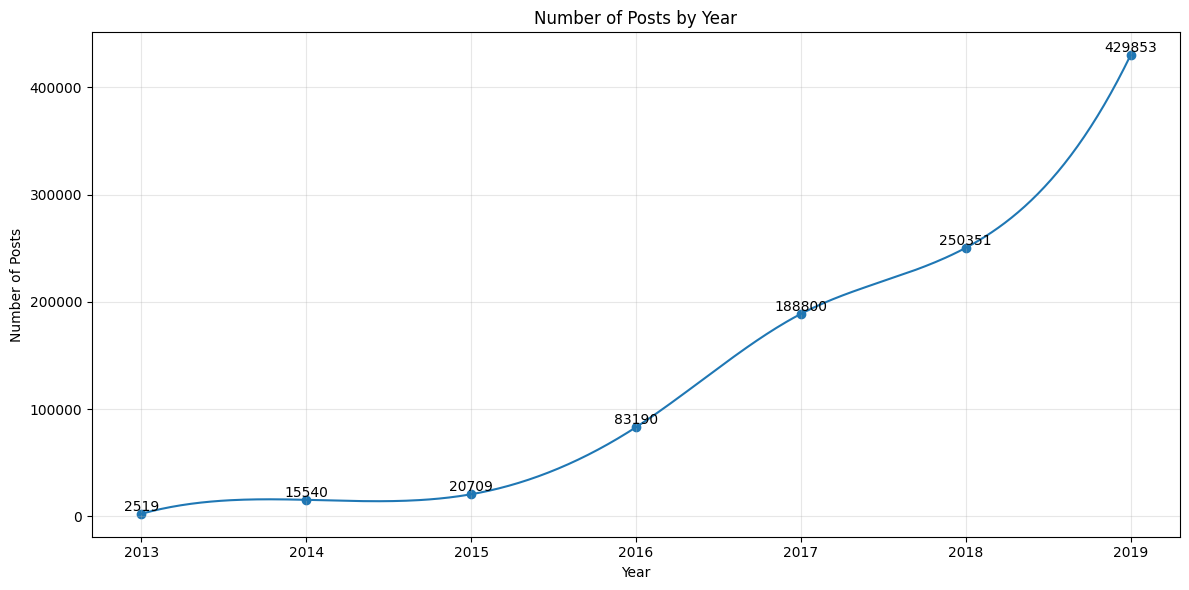

In [161]:
# Group by year and count
yearly_counts = combined_df['YEAR'].value_counts().sort_index()

# Create the plot

plt.figure(figsize=(12, 6))

# Create smooth curve
x = yearly_counts.index
y = yearly_counts.values
xnew = np.linspace(min(x), max(x), 300)
spl = make_interp_spline(x, y, k=3)
smooth = spl(xnew)

# Plot smooth curve and points
plt.plot(xnew, smooth, '-')
plt.scatter(x, y, marker='o')

plt.title('Number of Posts by Year')
plt.xlabel('Year')
plt.ylabel('Number of Posts')
plt.grid(True, alpha=0.3)

# Add value labels at each point
for i, j in zip(x, y):
    plt.text(i, j, str(int(j)), ha='center', va='bottom')

plt.tight_layout()
plt.show()

#### Number of Posts by Month (2016-2019)

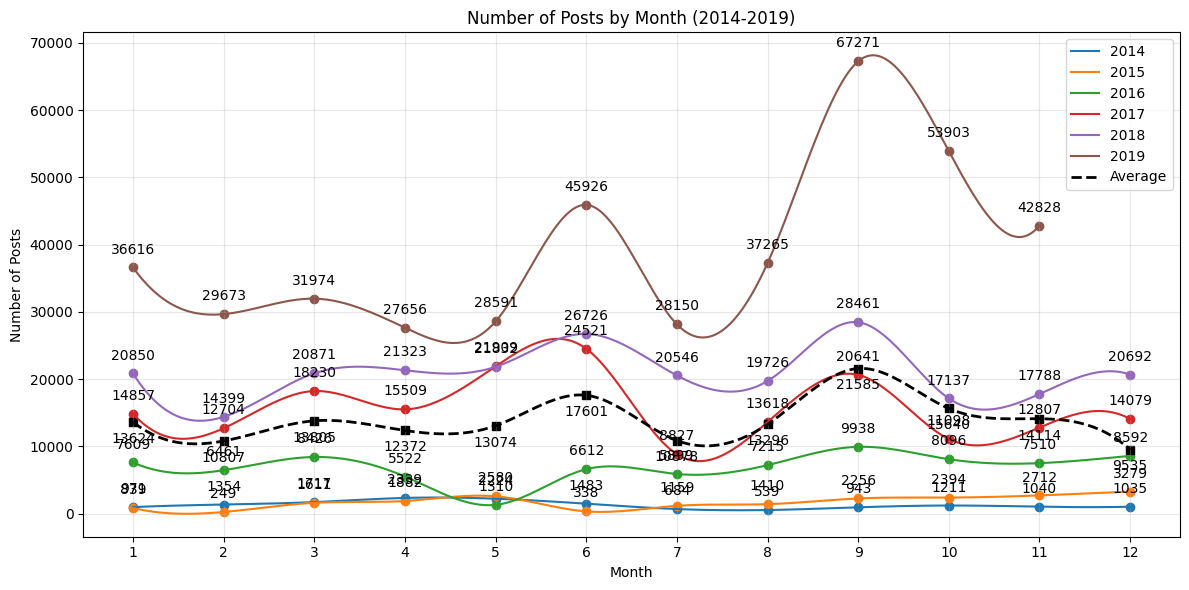

In [162]:
# Extract month and year from DATE
combined_df['Month'] = pd.to_datetime(combined_df['DATE']).dt.month
combined_df['Year'] = pd.to_datetime(combined_df['DATE']).dt.year

# Filter for years 2016-2019
df_2016_2019 = combined_df[(combined_df['Year'] >= 2014) & (combined_df['Year'] <= 2019)]

# Group by year and month, count posts
monthly_counts = df_2016_2019.groupby(['Year', 'Month']).size().reset_index(name='Count')

# Calculate average by month across years
monthly_avg = monthly_counts.groupby('Month')['Count'].mean().reset_index()

# Create the plot
plt.figure(figsize=(12, 6))

# Plot lines and points for each year
for year in monthly_counts['Year'].unique():
    year_data = monthly_counts[monthly_counts['Year'] == year]
    x = year_data['Month']
    y = year_data['Count']
    
    # Plot smoothed line
    xnew = np.linspace(min(x), max(x), 300)
    spl = make_interp_spline(x, y, k=3)
    smooth = spl(xnew)
    plt.plot(xnew, smooth, '-', label=str(int(year)))
    
    # Plot actual data points and values
    plt.scatter(x, y, marker='o')
    for i, txt in enumerate(y):
        plt.annotate(int(txt), (x.iloc[i], y.iloc[i]), 
                    textcoords="offset points", 
                    xytext=(0,10), 
                    ha='center')

# Plot average line with points
x_avg = monthly_avg['Month']
y_avg = monthly_avg['Count']

# Plot smoothed average line
xnew_avg = np.linspace(min(x_avg), max(x_avg), 300)
spl_avg = make_interp_spline(x_avg, y_avg, k=3)
smooth_avg = spl_avg(xnew_avg)
plt.plot(xnew_avg, smooth_avg, '--', label='Average', linewidth=2, color='black')

# Plot average data points and values
plt.scatter(x_avg, y_avg, color='black', marker='s')
for i, txt in enumerate(y_avg):
    plt.annotate(f'{txt:.0f}', (x_avg.iloc[i], y_avg.iloc[i]), 
                textcoords="offset points", 
                xytext=(0,-15), 
                ha='center',
                color='black')

plt.title('Number of Posts by Month (2014-2019)')
plt.xlabel('Month')
plt.ylabel('Number of Posts')
plt.grid(True, alpha=0.3)
plt.legend()

# Set x-axis ticks to show all months
plt.xticks(range(1,13))

plt.tight_layout()
plt.show()


#### Number of Posts by Month (2014-2019) - Stacked together 3 Dimensions

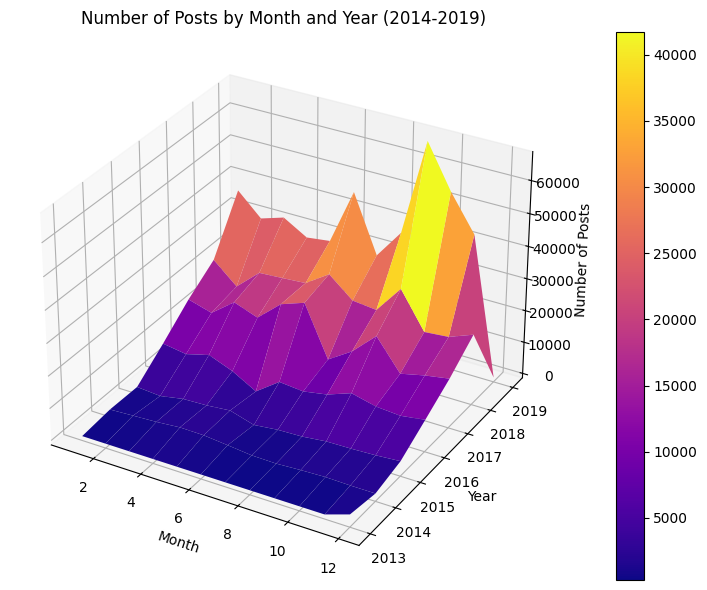

In [166]:
# Create a 3D plot
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, projection='3d')

# Get unique years
years = sorted(combined_df['Year'].unique())
months = range(1, 13)

# Create meshgrid for X (months) and Y (years)
X, Y = np.meshgrid(months, years)
Z = np.zeros_like(X, dtype=float)

# Fill Z values
for i, year in enumerate(years):
    year_data = combined_df[combined_df['Year'] == year]
    for j, month in enumerate(months):
        count = len(year_data[year_data['Month'] == month])
        Z[i,j] = count

# Create the surface plot
surf = ax.plot_surface(X, Y, Z, cmap='plasma')

# Customize the plot
ax.set_xlabel('Month')
ax.set_ylabel('Year')
ax.set_zlabel('Number of Posts')
ax.set_title('Number of Posts by Month and Year (2014-2019)')

# Add a color bar
fig.colorbar(surf)

plt.tight_layout()
plt.show()


#### Number of GSM-related Posts by Year (2013-2019, 2024)

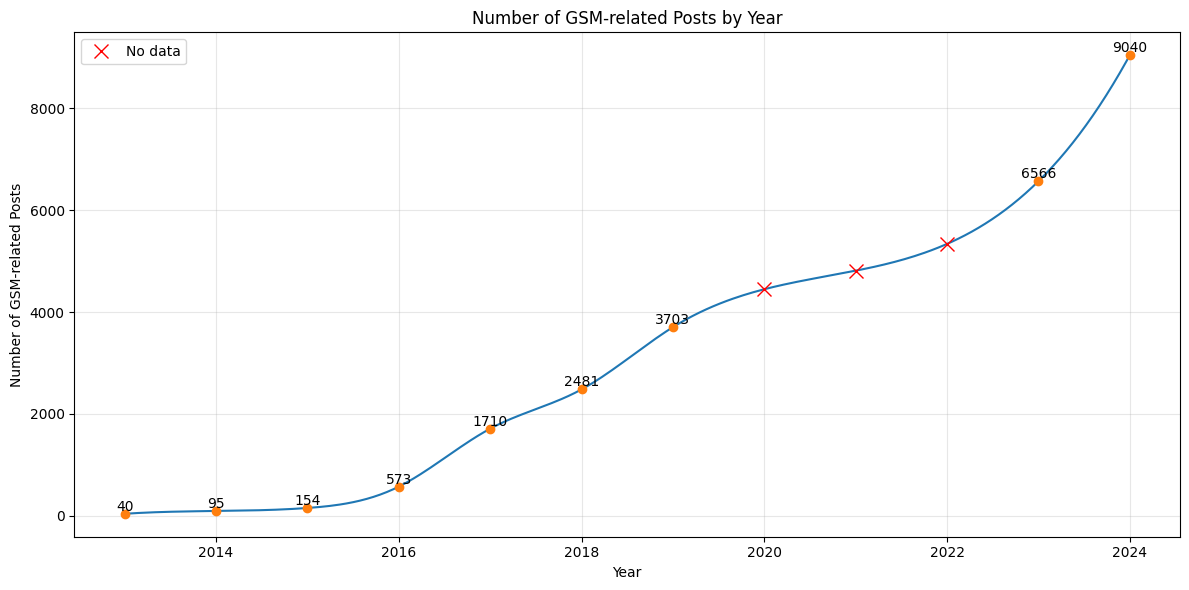

In [171]:
# Group by year and count
yearly_counts = gsm_final_df['YEAR'].value_counts().sort_index()

plt.figure(figsize=(12, 6))

# Create smooth curve
x = yearly_counts.index.astype(float)
y = yearly_counts.values
x_smooth = np.linspace(x.min(), x.max(), 300)
spl = make_interp_spline(x, y, k=3)
y_smooth = spl(x_smooth)

# Plot smooth curve and points
plt.plot(x_smooth, y_smooth, '-')
plt.plot(x, y, 'o')

# Add 'x' markers on the curve for years without data
all_years = np.arange(x.min(), x.max() + 1)
missing_years = [year for year in all_years if year not in x]
# For each missing year, find the corresponding y value on the smooth curve
missing_y = spl(missing_years)
plt.plot(missing_years, missing_y, 'rx', markersize=10, label='No data')

plt.title('Number of GSM-related Posts by Year')
plt.xlabel('Year')
plt.ylabel('Number of GSM-related Posts')
plt.grid(True, alpha=0.3)
plt.legend()

# Add value labels at each point
for x_val, y_val in zip(yearly_counts.index, yearly_counts.values):
    plt.text(x_val, y_val, str(int(y_val)), ha='center', va='bottom')

plt.tight_layout()
plt.show()